# Project 4 - QR Code Reader

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Part A: <span style="color:red;">3.5 hrs</span>
* 2. Part B: <span style="color:red;">2 hrs</span>
* 3. Part C: <span style="color:red;">1.5 hrs</span>
* 4. Tests: <span style="color:red;">15 min</span>
* 5. Challenge 1: <span style="color:red;">0 s (done along the way)</span>
* 6. Challenge 3: <span style="color:red;">0 s (done along the way)</span>
* 7. Challenge 4: <span style="color:red;">30 min</span>
* 8. Write-up: <span style="color:red;">30 min</span>

### Understanding QR Codes

QR codes (short for Quick Response Codes) were invented in 1994, by the DENSO Corporation. These codes store data in two dimensions in the form of an array of contrasting regions. The information density of a QR code is much higher than a vanilla barcode; depending on the format used and the resolution of reader, over a thousand bytes can be encoded in a region the size of a postage stamp.

QR codes use a Reed–Solomon error correction based technology to help recover from errors in reading (for instance, caused by a smudge, badly printed code or other deformity).

Any QR code can be broken into the following sections:

<div style="width:75%;text-align:center;"><img src="Images/formatting.jpg" width=100%></div>

On three corners of a QR code are square blocks that the reader uses to coarsely identify and then align the code. These will be of primary interest during the lab. Once these corners are identified and the image is aligned, the size of the QR code is determined by the timing information which alternates from black and white in both the vertical and horizontal direction. 

Once the image is aligned and the size determined, the QR code is discretized, undergoes an Xor with a particular mask given the format information, and read bit for bit in the following order:

<div style="width:75%;text-align:center;"><img src="Images/decoding.jpg" width=100%></div>

For more details about the decoding process, see the [DataGenetics Wounded QR Codes Blog](http://datagenetics.com/blog/november12013/index.html).

For this lab, we will focus primarily the computer vision side of QR codes, which involves detecting, aligning, and discretizing QR codes so that they can be read properly.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np # this is so that you can see which functions come from the numpy library
import matplotlib.pyplot as plt # this is so that you can see which functions come from the pyplot library
plt.rcParams['figure.figsize'] = [15,8]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'

import cv2
import time

def just_title(title):
    a = plt.gca()
    a.set_title(title, fontdict={'fontsize': rcParams['axes.titlesize'],
                                 'fontweight' : rcParams['axes.titleweight'],
                                 'verticalalignment': 'baseline',
                                 'horizontalalignment': 'center'})
    a.set_xticks([])
    a.set_yticks([])

### Part A: Finding Corners

QR codes are designed with a very specific pattern so that can efficiently be detected, oriented, and decoded. The first step to detecting a QR code is finding the position markers that are always present in three of the four corners. These position markers always have a black/white/black/white/black ratio of 1:1:3:1:1, no matter the angle they are approached from.

<div style="width:20%;text-align:center;"><img src="Images/finder_pattern.jpg" width=100%></div>

Preprocess your image by thresholding to black and white. Scan across rows of the image, marking locations that have the 1:1:3:1:1 ratio (note: this is most easily done by keeping multiple counters for black and white pixels).

<div style="width:20%;text-align:center;"><img src="Images/first_scan.jpg" width=100%></div>

Once you have candidate locations, verify the locations by also scanning vertically, diagonally and in other directions. Also complete a non maximal suppression to get your final three candidate points.

<div style="width:20%;text-align:center;"><img src="Images/candidates.JPG" width=100%></div>

In [3]:
def score(r, c):
    sums = []
    for i in [0, 1, 3, 4]:
        if c[i]*3 < c[2]+1.5 and c[i]*3 > c[2]-1.5:
            new_r = [k*c[i] for k in r]
            dist = 0
            for j in range(len(r)):
                dist += abs(new_r[j] - c[j])
            sums.append(dist)
        else:
            sums.append(np.inf)
    
    return min(sums)


def rle_append(r, c, a):
    threshold = 5
    
    c.append(a)
    if len(c) <= 5:
        return False, c
    else:
        c = c[1:]
        
    s = score(r, c)
    
    if s <= threshold:
        return True, c
    else:
        return False, c
    

def find_points(im, vertical=False):
    if vertical:
        im = im.transpose()
    
    # construct RLE
    ratio = [1, 1, 3, 1, 1]
    
    total = []  # list of center points
    for i in range(len(im)):
        acc = 0
        match = False
        counter = [42000]  # starts with a placeholder
        for j in range(len(im[i])):
            if j == 0:
                acc = 1
            elif im[i][j] < im[i][j-1] + 5 and im[i][j] > im[i][j-1] - 5:
                acc += 1
                if j == len(im[i])-1:
                    match, counter = rle_append(ratio, counter, acc)
            else:
                match, counter = rle_append(ratio, counter, acc)
                acc = 1
            if match:
                match_point = (i, int(j-counter[4]-counter[3]-(counter[2]/2)))
                if im[match_point[0]][match_point[1]] < 120:  # only add point if center is dark
                    total.append(match_point)

                match = False
    
    return total

In [4]:
def find_n_centers(v, n):
    k = np.array([[1, 1, 1, 1, 1],
                  [1, 1, 1, 1, 1],
                  [1, 1, 8, 1, 1],
                  [1, 1, 1, 1, 1],
                  [1, 1, 1, 1, 1]])
    res = ndimage.convolve(v, k)
    
    spots = []
    for i in range(n):
        _, _, _, max_loc = cv2.minMaxLoc(res)
        res = cv2.circle(res, max_loc, 5, 0, -1)
        spots.append(max_loc)
    
    return spots

In [5]:
from scipy import ndimage

def find_centers(file, show=False):
    image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    image_t = (image > 122) * 255

    votes = np.zeros(image.shape)

    # find horizontal points
    h = find_points(image_t, vertical=False)
    for x,y in h:
        image[x][y] = 120
        votes[x][y] += 1

    # find vertical points
    v = find_points(image_t, vertical=True)
    for x,y in v:
        image[y][x] = 120
        votes[y][x] += 1
    
    # count votes and pick 3 centers
    pts = find_n_centers(votes, 3)
    for p in pts:
        image = cv2.circle(image, p, 3, 255, -1)
        
    if show:
        plt.subplot(121)
        plt.imshow(image, cmap="gray")
        just_title("3 Centers")

        plt.subplot(122)
        plt.imshow(votes, cmap="gray", vmin=0, vmax=2)
        just_title("Votes")

        plt.show()
    
    return pts

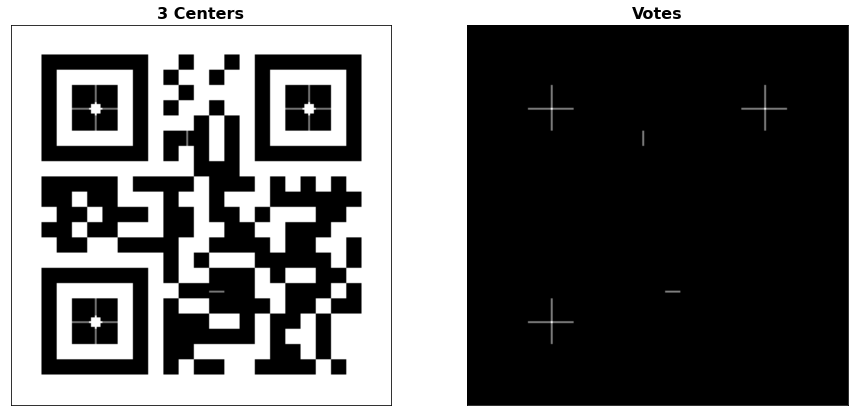

In [6]:
centers = find_centers("QR_codes/test1.png", show=True)

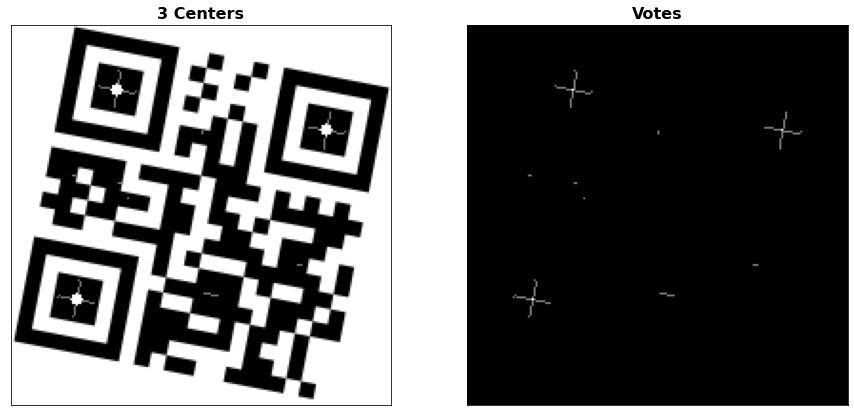

In [7]:
centers = find_centers("QR_codes/test2.png", show=True)

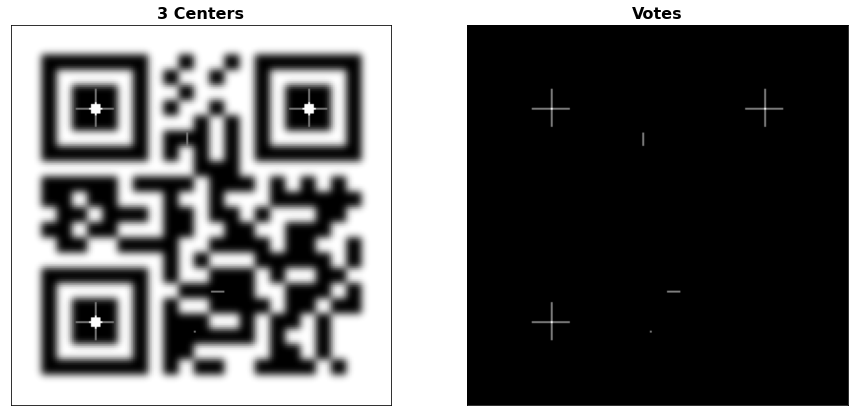

In [8]:
centers = find_centers("QR_codes/test3.png", show=True)

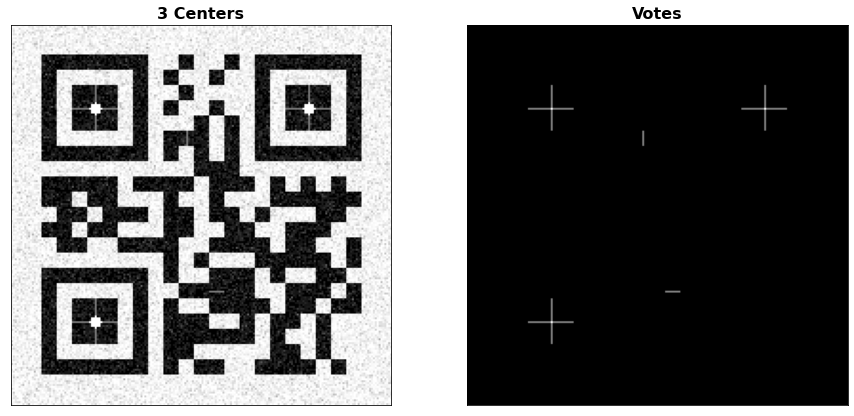

In [9]:
centers = find_centers("QR_codes/test4.png", show=True)

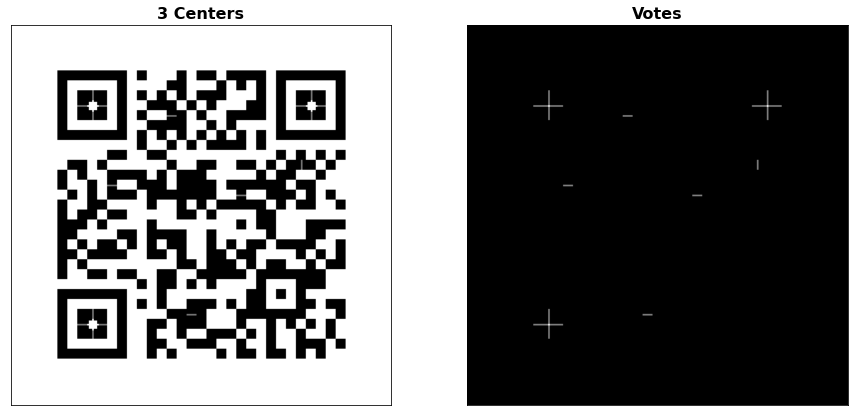

In [10]:
centers = find_centers("QR_codes/test5.png", show=True)

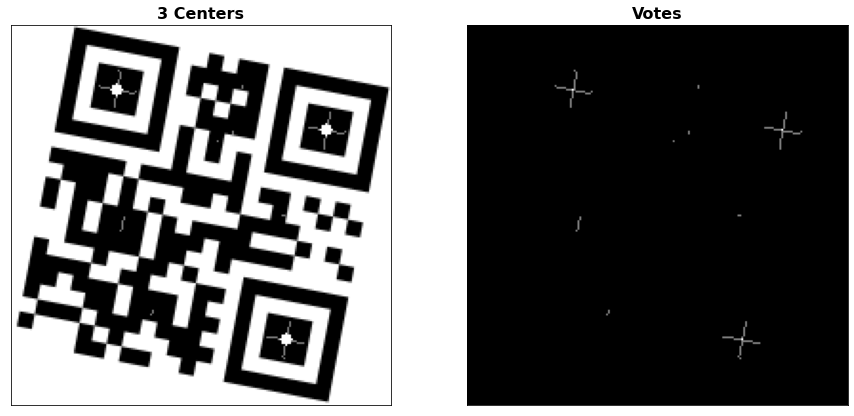

In [11]:
centers = find_centers("QR_codes/challenge1.png", show=True)

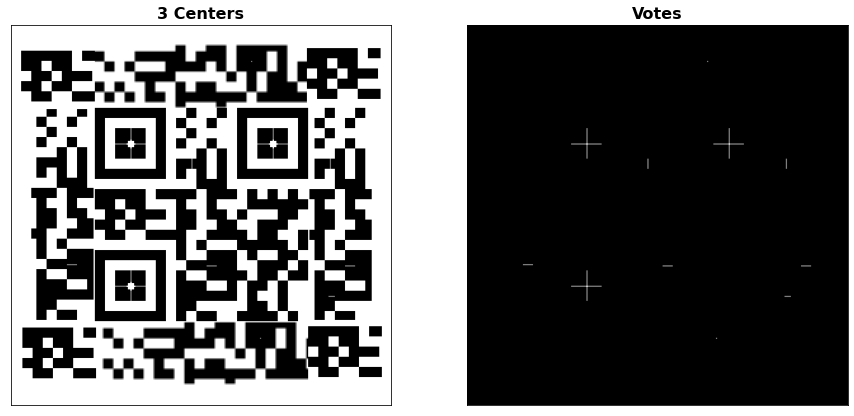

In [12]:
centers = find_centers("QR_codes/challenge3.png", show=True)

### Part B: Finding The Fourth Point and Aligning with a Homography

QR codes only contain three known corner points, but homographies require four points to be defined. If the warping present in the image is small enough, an affine transform is generally sufficient to find the fourth point (i.e. the *x,y* coordinate difference between point 1 and point 2 will be the same as the *x,y* coordinate difference between point 3 and point 4). Use this assumption to find the fourth point.

<div style="width:20%;text-align:center;"><img src="Images/four_points.JPG" width=100%></div>

Once you have the four points, generate the homography that would align the QR code with the *x,y* axes. Crop the aligned image until only the QR code is visible.

<div style="width:20%;text-align:center;"><img src="Images/aligned.jpg" width=100%></div>

In [13]:
def find_last_center(im, c, show=False):
    c.sort(key=lambda y: y[1])

    dx = c[1][0] - c[0][0]
    dy = c[1][1] - c[0][1]
    
    if c[2][0]+dx > im.shape[0] or c[2][1]+dy > im.shape[1]:
        c.insert(2, (c[2][0]-dx, c[2][1]-dy))
    else:
        c.append((c[2][0]+dx, c[2][1]+dy))
        
    if show:
        for cent in c:
            im = cv2.circle(im, cent, 3, 122, -1)
        
        plt.imshow(im, cmap="gray")
        just_title("4 Centers")

        plt.show()
        
    return c

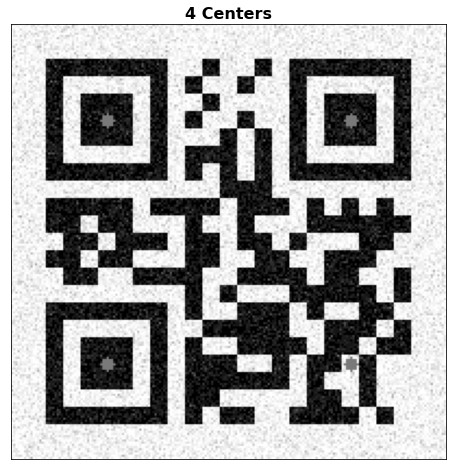

In [14]:
file = "QR_codes/test4.png"
image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
centers = find_centers(file, show=False)

centers = find_last_center(image, centers, show=True)

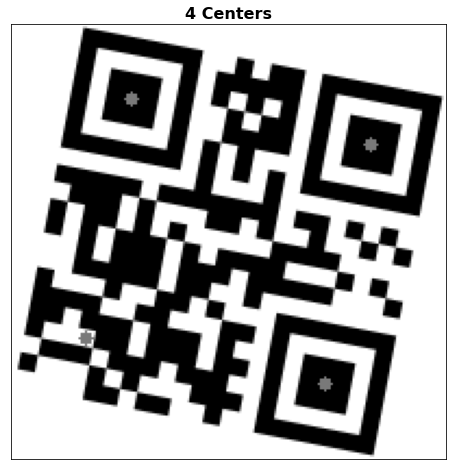

In [15]:
file = "QR_codes/challenge1.png"
image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
centers = find_centers(file, show=False)

centers = find_last_center(image, centers, show=True)

In [16]:
# to make the matrices for the four-point algorithm

def construct_matrices(points, points_pr):
    A_matrix = []
    b_vector = []
    for (x, y), (x_pr, y_pr) in zip(points, points_pr):
        A_matrix.append([x, y, 1, 0, 0, 0, -1 * x_pr * x, -1 * x_pr * y])
        b_vector.append([x_pr])
        A_matrix.append([0, 0, 0, x, y, 1, -1 * y_pr * x, -1 * y_pr * y])
        b_vector.append([y_pr])
        
    return np.asarray(A_matrix), np.asarray(b_vector)

In [17]:
def find_homography(centers):
    desired_pts = ((34, 34), (166, 34), (34, 166), (166, 166))
    A, b = construct_matrices(centers, desired_pts)
    
    # find homography
    h_vector = np.linalg.solve(A, b)
    
    # make homography square
    h_vector = np.append(h_vector, [[1.0]], axis=0)
    h = h_vector.reshape((3, 3))
    
    return h

In [18]:
def transform(im, centers, show=False):
    # find homography
    homo = find_homography(centers)

    # apply homography
    window_size = (200, 200)
    im_warped = cv2.warpPerspective(im, homo, window_size, borderValue=255)
    
    # threshold image
    im_warped = (im_warped > 122) * 255
    im_warped = im_warped.astype(np.uint8)
    
    # crop image (remove surrounding whitespace)
    x1, y1 = 0, 0
    x2, y2 = window_size
    for row in im_warped:
        if min(row) == 255:
            x1 += 1
        else:
            break
            
    for row in im_warped[::-1]:
        if min(row) == 255:
            x2 -= 1
        else:
            break
            
    for col in im_warped.T:
        if min(col == 255):
            y1 += 1
        else:
            break
            
    for col in im_warped.T[::-1]:
        if min(col) == 255:
            y2 -= 1
        else:
            break

    im_warped = im_warped[x1:x2, y1:y2]
            
    if show:
        plt.subplot(121)
        plt.imshow(im, cmap="gray")
        just_title("Original")

        plt.subplot(122)
        plt.imshow(im_warped, cmap="gray")
        just_title("QR Code Warped and Cropped")

        plt.show()
    
    return im_warped

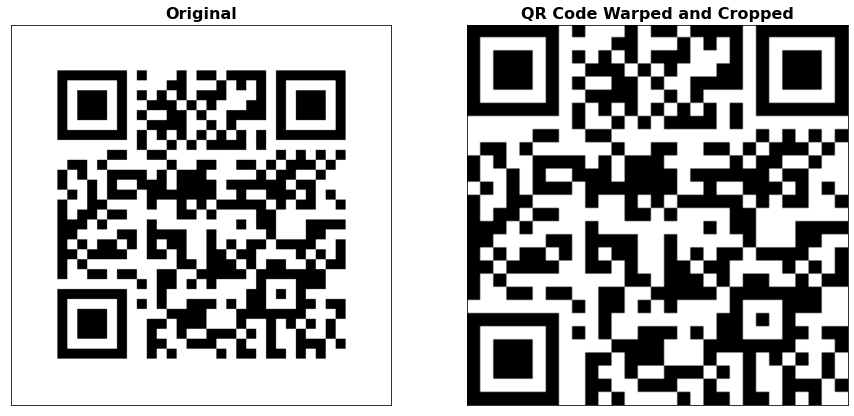

In [19]:
file = "QR_codes/test5.png"
image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

centers = find_centers(file)

centers = find_last_center(image, centers)

new_im = transform(image, centers, show=True)

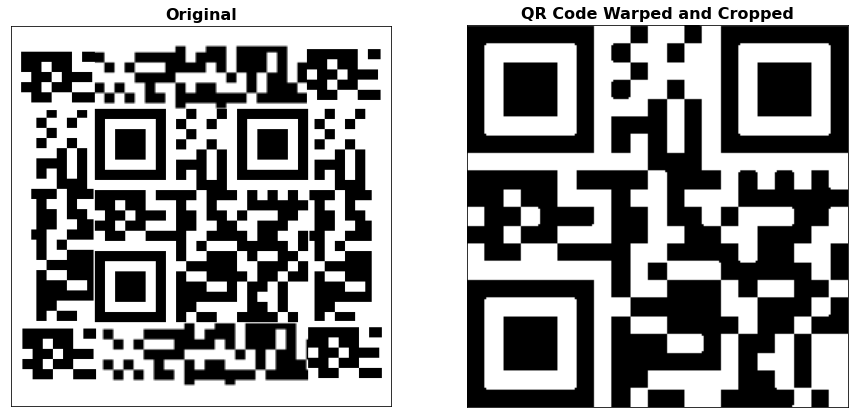

In [20]:
file = "QR_codes/challenge3.png"
image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
centers = find_centers(file)

centers = find_last_center(image, centers)

new_im = transform(image, centers, show=True)

### Part C: Discretization

Now that the image is aligned, the QR code needs to discretized so that each block is a single bit, rather than a group of pixels. The simplest way to do this is to count the number of black and white pixels in a region and assign the block to the highest count. However, to do this, the size of the QR code needs to be determined. All QR codes have an odd number of bits per row and column, starting at size 21 and incrementing by 4 (i.e. 21x21, 25x25, 29x29, ...). For this lab, you will only need to check for sizes from 21 to 33.

To check if a QR code matches a given size, discretize the QR code asumming the given size. Then, determine if the timing information alternates in the appropriate manner (see the Understanding QR Codes for more information). If the timing information is valid, then you can assume that the QR code is the given size.

Once you have the correct size, discretize the QR code accordingly and return a Numpy array of True/False values.


In [21]:
from scipy import stats

def discretize(qr_code, size):
#     manual way to do it...
#     bit_size = (qr_code.shape[0]/size, qr_code.shape[1]/size)
    
#     res = np.zeros((size, size))
#     for i in range(size):
#         for j in range(size):
#             window = qr_code[int(i*bit_size[0]):int((i+1)*bit_size[0]), int(j*bit_size[1]):int((j+1)*bit_size[1])]
#             if np.count_nonzero(window) > window.size/2:
#                 res[i][j] = 1

    res = cv2.resize(qr_code, (size, size))
    res = res > 122
    
    return res


def discretize_size(qr_code, show=False):
    if show:
        plt.imshow(qr_code, cmap="gray")
        just_title("QR Code")
        
        plt.show()

    for size in [21, 25, 29, 33]:
        d = discretize(qr_code, size)
        
        # check if timing marks are right
        if size == 21: timing = [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
        elif size == 25: timing = [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
        elif size == 29: timing = [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
        else: timing = [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
            
        if np.array_equal(d[6], timing) and np.array_equal(d.T[6], timing) or np.array_equal(d.T[-7], timing):
            if show:
                print("QR Code is shape:", d.shape)
            d = (d == 1)
            return d
    
    print("Discretization failed")
    return False

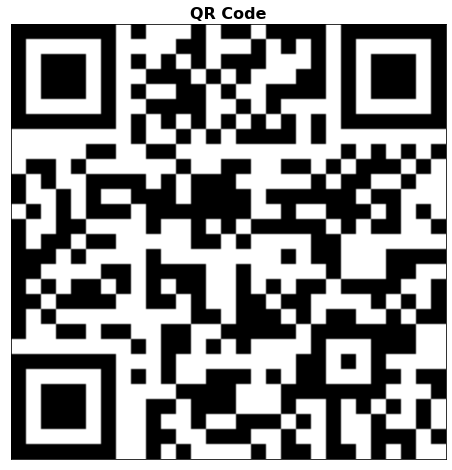

QR Code is shape: (29, 29)


In [22]:
file = "QR_codes/test5.png"
image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
centers = find_centers(file)
centers = find_last_center(image, centers)
new_im = transform(image, centers)

d_arr = discretize_size(new_im, show=True)

### Part D: Decoding

QR codes are decoded using a very particular block pattern (see Understanding QR Codes). However, for simplicity, we have implemented this decoder for you. To use it, simply call `decode()` from the decoder.py file and feed it your 2D Numpy array. It will return a string with the QR code data.

**Note: You may need to run** `conda install beautifulsoup4` **and** `conda install requests` **to get the decoder to run.**

In [23]:
from decoder import decode

def print_QR(filename, show=False):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    centers = find_centers(filename)
    centers_4 = find_last_center(image, centers)
    new_im = transform(image, centers_4)
    
    if show:
        plt.imshow(new_im, cmap="gray")
        just_title("Final QR Code")

        plt.show()
        
    d_arr = discretize_size(new_im)
    
    if d_arr is not False:
        output = decode(d_arr)
        return output, new_im

In [24]:
link, _ = print_QR("QR_codes/challenge3.png", show=False)
print(link)

http://byu.edu


## Tests

Once you have your full algorithm working, run your code on the five test images in the *QR_codes* folder. Show your results below.

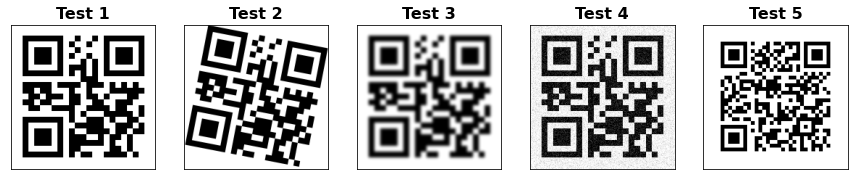

In [25]:
im = cv2.imread("QR_codes/test1.png", cv2.IMREAD_GRAYSCALE)
plt.subplot(151)
plt.imshow(im, cmap="gray")
just_title("Test 1")

im = cv2.imread("QR_codes/test2.png", cv2.IMREAD_GRAYSCALE)
plt.subplot(152)
plt.imshow(im, cmap="gray")
just_title("Test 2")

im = cv2.imread("QR_codes/test3.png", cv2.IMREAD_GRAYSCALE)
plt.subplot(153)
plt.imshow(im, cmap="gray")
just_title("Test 3")

im = cv2.imread("QR_codes/test4.png", cv2.IMREAD_GRAYSCALE)
plt.subplot(154)
plt.imshow(im, cmap="gray")
just_title("Test 4")

im = cv2.imread("QR_codes/test5.png", cv2.IMREAD_GRAYSCALE)
plt.subplot(155)
plt.imshow(im, cmap="gray")
just_title("Test 5")

plt.show()

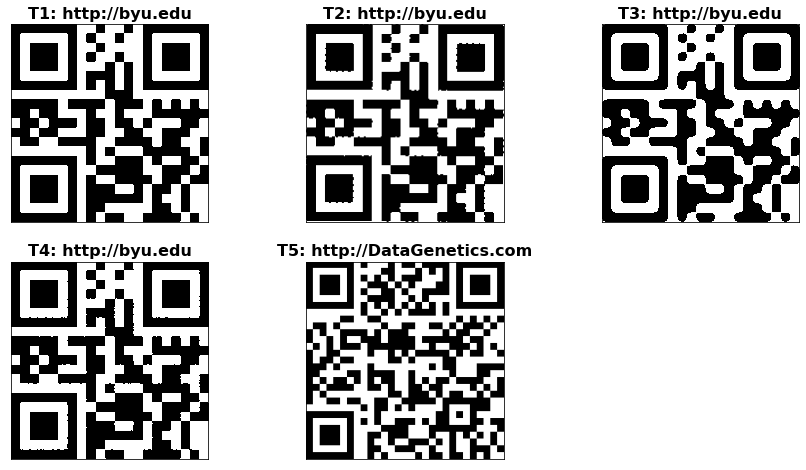

In [26]:
plt.subplot(231)
o, image = print_QR("QR_codes/test1.png")
plt.imshow(image, cmap="gray")
just_title("T1: "+o)

plt.subplot(232)
o, image = print_QR("QR_codes/test2.png")
plt.imshow(image, cmap="gray")
just_title("T2: "+o)

plt.subplot(233)
o, image = print_QR("QR_codes/test3.png")
plt.imshow(image, cmap="gray")
just_title("T3: "+o)

plt.subplot(234)
o, image = print_QR("QR_codes/test4.png")
plt.imshow(image, cmap="gray")
just_title("T4: "+o)

plt.subplot(235)
o, image = print_QR("QR_codes/test5.png")
plt.imshow(image, cmap="gray")
just_title("T5: "+o)

plt.show()

## Grading and Challenges
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly finds the three corners of the QR code.
* [20 pts] Code that aligns the QR code and crops appropriately.
* [20 pts] Code that correctly discretizes for an arbitrary size.
* [10 pts] For a full algorithm that correctly scans the five test images.

The last 30 points are earned through completing a subset of the following challenges:

* [15 pts] Correctly scan a QR code that is misaligned by more than 90 degrees (e.g. challenge1.png)
* [15 pts] Correctly scan a QR code that is perspective shifted by using the additional alignment square present in larger QR codes. (e.g. challenge2.png)
* [15 pts] Correctly scan a QR code that is surrounded by additional pixels (e.g. challenge3.png)
* [15 pts] Correctly scan a QR code with large amounts of noise and distortion (e.g. challenge4.png)
* [30 pts] Implement a Code 128 1D bar code scanner (e.g. challenge5.png)

You may earn up to 15 points extra credit for additional challenges you complete.



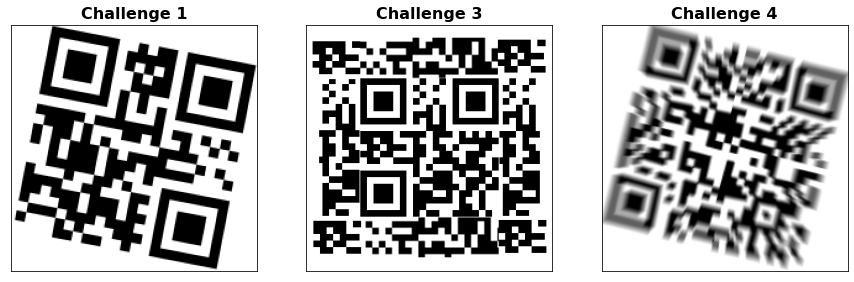

In [27]:
im = cv2.imread("QR_codes/challenge1.png", cv2.IMREAD_GRAYSCALE)
plt.subplot(131)
plt.imshow(im, cmap="gray")
just_title("Challenge 1")

im = cv2.imread("QR_codes/challenge3.png", cv2.IMREAD_GRAYSCALE)
plt.subplot(132)
plt.imshow(im, cmap="gray")
just_title("Challenge 3")

im = cv2.imread("QR_codes/challenge4.png", cv2.IMREAD_GRAYSCALE)
plt.subplot(133)
plt.imshow(im, cmap="gray")
just_title("Challenge 4")

plt.show()

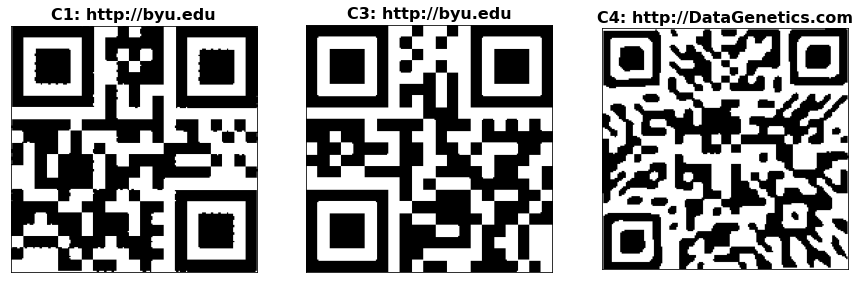

In [28]:
plt.subplot(131)
o, image = print_QR("QR_codes/challenge1.png")
plt.imshow(image, cmap="gray")
just_title("C1: "+o)

plt.subplot(132)
o, image = print_QR("QR_codes/challenge3.png")
plt.imshow(image, cmap="gray")
just_title("C3: "+o)

plt.subplot(133)
o, image = print_QR("QR_codes/challenge4.png")
plt.imshow(image, cmap="gray")
just_title("C4: "+o)

plt.show()


## Write-up:
Provide an explanation for the following items:
* Which part of this lab did you find most difficult?
* For each challenge completed, explain how you were able to solve the problem presented.
* What improvements would you recommend for this lab?

<span style="color:red;">Definitely finding the corners was hardest for me. It helped a lot when I remembered to threshold the image. Also it took me a good while to learn how best to find the [1, 1, 3, 1, 1] ratio, while allowing for a little pixel variance. Once I figured that part out, the rest wasn't too bad. I overcomplicated a few parts, but it works great!</span>

<span style="color:red;">I did challenges 1, 3, and 4! The first two (1 and 3) were done along the way. Challenge 3 presented no challenge whatsoever, since using the 4 corners found to apply a homography automatically cuts off the surrounding information.</span>
    
<span style="color:red;">Challenge 1 required a little more work in two areas. First, I had to change my method for finding the 4th corner slightly. With all the other QR codes, I used the distance between the top two points applied to the 3rd point to find the 4th point. When this is done with challenge 1 however, the calculated 4th point is off the image. So, I simply said that if the 4th point is calculated off the image, flip it by applying a negative transformation instead. This worked well. The second change I had to make was for when I confirmed the size of the QR code. Basically I had to allow for the vertical timing strip to be on the right side, not just the left.</span>

<span style="color:red;">After finishing everything else, I decided to go back and try challenge 4! To make this one work, I first add to increase my threshold for finding the [1,1,3,1,1] in the corners. (However I had to keep it low enough that all the other tests would still work!) After that, I had to switch my discretization from doing it manually to just using cv2.resize(). This change made the discretization work, and it works on all the other tests too!</span>

<span style="color:red;">It was a good time! The only change I think would be to remove the 1D barcode option, or make it required for all. As it is right now, it seems that those who do it don't have much help.</span>